# Artificial data

In [1]:
import numpy as np

np.random.seed(0)
N = 10000
data1 = np.random.multivariate_normal(mean=[2, 2, 2, 2], cov=np.eye(4)* 0.01, size=N)
cov = np.eye(4)
cov[1, 2] = cov[2, 1] = 1
cov[2, 3] = cov[3, 2] = 1
cov[1, 3] = cov[3, 1] = 1
data2 = np.random.multivariate_normal(mean=[-8, 4, 4, 4], cov=cov* 0.01, size=N)

cov = np.eye(4)
cov[2, 3] = cov[3, 2] = 1
data3 = np.random.multivariate_normal(mean=[-8, 8, 4, 4], cov=cov* 0.01, size=N)


data = np.concatenate([data1, data2, data3], axis = 0)

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state = 0)
print (len(train), len(test))

22500 7500


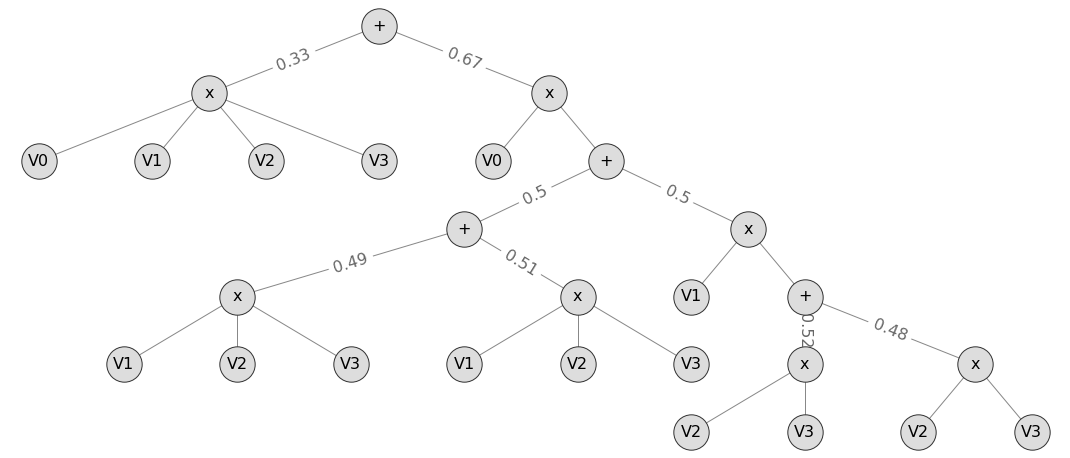

In [3]:
from spn.io.Graphics import plot_spn
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

import matplotlib.pyplot as plt
%matplotlib inline


names = ['V%d' % i for i in range(4)]
ptypes = [Gaussian]*len(names)
categorical = [False]*len(names)

context =  Context(parametric_types=ptypes).add_domains(train)
net = learn_parametric(train, 
                       ds_context = context, 
                       rows="gmm", 
                       min_instances_slice = len(train) / 5)

plt.figure(figsize=(15, 6.5))
plot_spn(net)
plt.tight_layout(pad= 1.2)

In [25]:
from spn.structure.Base import Sum, Product, Leaf, get_nodes_by_type, get_topological_order
from spn.algorithms.Inference import log_likelihood

sum_nodes = [node for node in get_topological_order(net)[::-1] if type(node) == Sum]
node = sum_nodes[0]

y = np.concatenate([log_likelihood(node.children[0], train), log_likelihood(node.children[1], train)], 
              axis=1).argmax(axis=1)

In [37]:
data = train
for node in get_topological_order(net)[::-1]:
    if type(node) == Leaf:
        continue
    if not hasattr(node, "data"):
        node.data = data
    if type(node) == Product:
        for child in node.children:
            child.data = node.data
    elif type(node) == Sum:
        likelihoods = np.concatenate([log_likelihood(child, node.data) for child in node.children], axis=1)
        y = likelihoods.argmax(axis=1)
        node.X = node.data
        node.y = y
        for i, child in enumerate(node.children):
            child.data = node.data[node.y == i]

net.children[1].children[1].X.shape

(14988, 4)

In [10]:
net.weights = net.weights[::-1]
net.children = net.children[::-1]

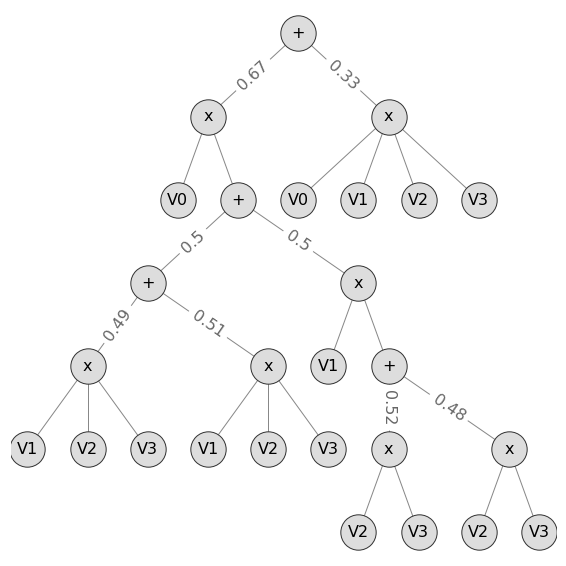

In [14]:
plt.figure(figsize=(8, 8))
plot_spn(net, "artificial_spn.pdf")
plt.tight_layout(pad= 1.2)

In [4]:
import csi2
from spn.structure.Base import get_nodes_by_type, Product



def format_condition(condition):
    try:
        a, sign, b = condition.split(" ")
    except ValueError as e:
        raise ValueError("Some nodes don't have conditions. reduce min_impurity_decrease")
    return "%s %s %.4f" % (a, sign, float(b))

print ('#product nodes = ', len(get_nodes_by_type(net, (Product))))

csi2.annotate_spn(net, names, categorical, 
             min_impurity_decrease = 0.1, max_depth = 2)
rules = csi2.context_specific_independences(net, instance_threshold = 0)


rules = csi2.context_specific_independences(net, instance_threshold = 0)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

rules = csi2.context_specific_independences(net, instance_threshold = len(train) / 5,
                                           precision_threshold = 0.7, recall_threshold = 0.7)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

#product nodes =  7
7, 2.29, 2.57
3, 1.33, 2.67


In [9]:
list(csi2.tree_edges(net, 0, 0, 0))

[([], ['V0', 'V1', 'V2', 'V3'], 1.0, 1.0, 22500),
 ([['V0 > -3.0403966903686523']],
  [['V0'], ['V1'], ['V2'], ['V3']],
  1.0,
  1.0,
  7512),
 ([['V0 <= -3.0403966903686523']],
  [['V0'], ['V1', 'V2', 'V3']],
  1.0,
  1.0,
  14988),
 ([['V0 <= -3.0403966903686523']], ['V1', 'V2', 'V3'], 1.0, 1.0, 14988),
 ([['V0 <= -3.0403966903686523'], ['V1 <= 6.063060760498047']],
  ['V1', 'V2', 'V3'],
  1.0,
  1.0,
  7508),
 ([['V0 <= -3.0403966903686523'], ['V1 > 6.063060760498047']],
  [['V1'], ['V2', 'V3']],
  1.0,
  1.0,
  7480),
 ([['V0 <= -3.0403966903686523'],
   ['V1 <= 6.063060760498047'],
   ['V3 <= 3.9971706867218018']],
  [['V1'], ['V2'], ['V3']],
  1.0,
  1.0,
  3656),
 ([['V0 <= -3.0403966903686523'],
   ['V1 <= 6.063060760498047'],
   ['V3 > 3.9971706867218018']],
  [['V1'], ['V2'], ['V3']],
  1.0,
  1.0,
  3852),
 ([['V0 <= -3.0403966903686523'], ['V1 > 6.063060760498047']],
  ['V2', 'V3'],
  1.0,
  1.0,
  7480),
 ([['V0 <= -3.0403966903686523'],
   ['V1 > 6.063060760498047'],
   [

In [7]:
csis

['{V0 > -3.0404} => {(V0), (V1), (V2), (V3)} | 1.00, 1.00, 7512 | 1 4',
 '{V0 <= -3.0404} => {(V0), (V1,V2,V3)} | 1.00, 1.00, 14988 | 1 2',
 '{[V0 <= -3.0404] & [V1 > 6.0631]} => {(V1), (V2,V3)} | 1.00, 1.00, 7480 | 2 2']

In [8]:
from spn.algorithms.Inference import log_likelihood

print ("%.2f" % np.mean(log_likelihood(net, test)))

2.83
